In [1]:
import torch
import numpy as np
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy,vq
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pathlib import Path
import os 
import pickle as pkl
import pandas as pd
import seaborn as sns
from txgnn import TxData

/home/tysinger/.conda/envs/txgnn_env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_encodings(file_path):
    encoding_data = torch.load(file_path)
    return list(encoding_data['mean_representations'].values()), encoding_data['gene_id']



def get_data(file_path):
    i = 0
    tmp = []
    labels = []
    encodings = np.array([])

    for filename in os.listdir(file_path):
        new_file_path = os.path.join(file_path, filename)
        if os.path.isfile(new_file_path) and filename.endswith('.pt'):
            i += 1
            # Process only files with the '.pt' extension
            (data,name) = load_encodings(file_path)
            print(data,name)
            labels.append(name)
            tmp.append(data)
    print(tmp)
    print(labels)
    return None
    print(len(tmp))
    encodings = np.append(encodings,tmp)
    encodings = np.reshape(encodings,(i,len(encodings)//i))
    return encodings,labels

In [3]:
def get_data(file_path):
    i = 0
    tmp = []
    labels = []
    encodings = np.array([])

    for filename in os.listdir(esm_encoding_file_path):
        file_path = os.path.join(esm_encoding_file_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.pt'):
            i += 1
            # Process only files with the '.pt' extension
            (data,name) = load_encodings(file_path)
            labels.append(name)
            tmp.append(data[0])
    encodings = torch.vstack(tmp)
    #encodings = np.reshape(encodings,(i,len(encodings)//i))
    return encodings,labels

In [4]:
esm_encoding_file_path = Path('/om/user/tysinger/TxGNN/embeddings/esm_embeddings')
encodings,labels = get_data(esm_encoding_file_path)

In [5]:
esm_embed_path = '/om/user/tysinger/embeddings/protgnn_finetune_esm.pkl'
with open(esm_embed_path, 'rb') as f:
    esm_embed = pkl.load(f)

#random_embed_path = '/om/user/tysinger/models/node_emb.pkl'
random_embed_path = '/om/user/tysinger/embeddings/protgnn_finetuned_noesm.pkl'
with open(random_embed_path, 'rb') as f:
    random_embed = pkl.load(f)

In [6]:
method = 't-SNE'

In [7]:
if method=='UMAP':
    trans = umap.UMAP(n_neighbors=5,n_jobs=30)
elif method=='t-SNE':
    trans = TSNE(n_components=2, random_state=42,n_jobs = 30)
elif method == 'PCA':
    trans = PCA(n_components=2,)

In [8]:
print(f'computing {method} of initializations')
esm_init        = trans.fit_transform(encodings)

print(f'computing {method} of esm_final')
esm_embeddings  = trans.fit_transform(esm_embed['gene/protein']) 

print(f'computing {method} of rand_final')
rand_embeddings = trans.fit_transform(random_embed['gene/protein']) 

computing t-SNE of initializations
computing t-SNE of esm_final
computing t-SNE of rand_final


In [9]:
def convert2str(x):
    try:
        if '_' in str(x): 
            pass
        else:
            x = float(x)
    except:
        pass


In [10]:
data_path = '/om/user/tysinger/kg/'
TxData_inst = TxData(data_folder_path = data_path)
TxData_inst.prepare_split(split = 'random', seed = 42, no_kg = False)
mappings = TxData_inst.retrieve_id_mapping()
mappings.keys()

Found local copy...
Found local copy...
Found local copy...
Found saved processed KG... Loading...
Splits detected... Loading splits....
Creating DGL graph....
Done!


dict_keys(['id2name_prot', 'id2name_molfunc', 'idx2id_molfunc', 'idx2id_ptor'])

In [11]:
idx2id = mappings['idx2id_ptor']
id2name = mappings['id2name_prot']

In [12]:
## compute clusters ## 
print('computing clusters')
k = KMeans(n_clusters = 20,random_state=42)
# clusters_init_hier = hierarchy.fclusterdata(encodings,t=0.05)
clusters_init = k.fit_predict(encodings)


#cmap = dipy.get_colormap(dipy.get_colors(20))
#cmap45 = dipy.get_colormap(dipy.get_colors(45))

computing clusters


In [13]:
clusters_final = k.fit_predict(esm_embed['gene/protein'])
name2cluster = dict(zip(labels,clusters_init))
cluster_name = np.zeros((len(esm_embeddings),))
for i in range(len(esm_embeddings)):
    try:
        cluster_name[i] = name2cluster[id2name[idx2id[i]]]
    except:
        cluster_name[i] = -1

/tmp/ipykernel_3110457/3041070781.py:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(clusters_init), vmax=max(clusters_init))))


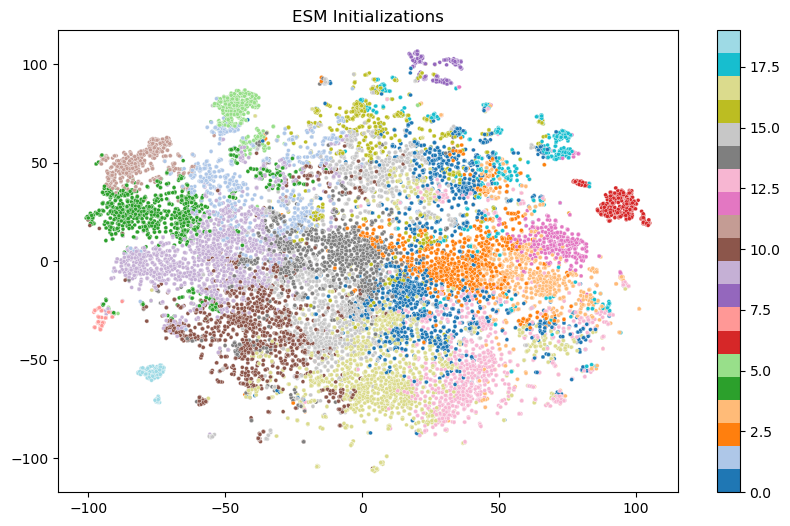

In [55]:
cmap = sns.color_palette("tab20", as_cmap=True)
#cmap = sns.color_palette("husl", 20, as_cmap=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=esm_init[:, 0], y=esm_init[:, 1], hue=clusters_init, palette=cmap, s=8, alpha = 1, legend=False)
plt.title("ESM Initializations")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(clusters_init), vmax=max(clusters_init))))
plt.show()

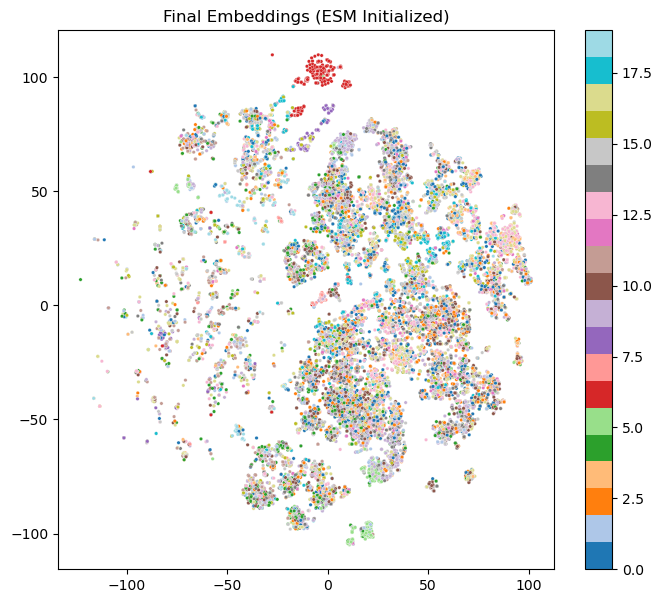

In [14]:
mask = cluster_name != -1
filtered_embeddings = esm_embeddings[mask]
filtered_c = cluster_name[mask]


cmap = sns.color_palette("tab20", as_cmap=True)

plt.figure(figsize=(8, 7))
scatter = sns.scatterplot(x=filtered_embeddings[:, 0], y=filtered_embeddings[:, 1], hue=filtered_c, 
                          palette=cmap, s=6, marker='o', legend=None)

plt.title(f"Final Embeddings (ESM Initialized)")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(clusters_init), vmax=max(clusters_init))))
plt.show()

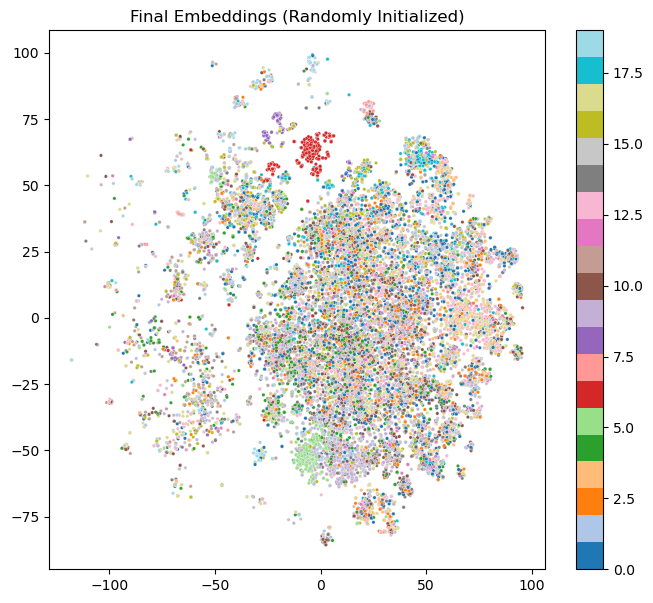

In [15]:
filtered_embeddings = rand_embeddings[mask]
cmap = sns.color_palette("tab20", as_cmap=True)

plt.figure(figsize=(8, 7))
scatter = sns.scatterplot(x=filtered_embeddings[:, 0], y=filtered_embeddings[:, 1], hue=filtered_c, 
                          palette=cmap, s=6, marker='o', legend=None)

plt.title(f"Final Embeddings (Randomly Initialized)")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(clusters_init), vmax=max(clusters_init))))
plt.show()

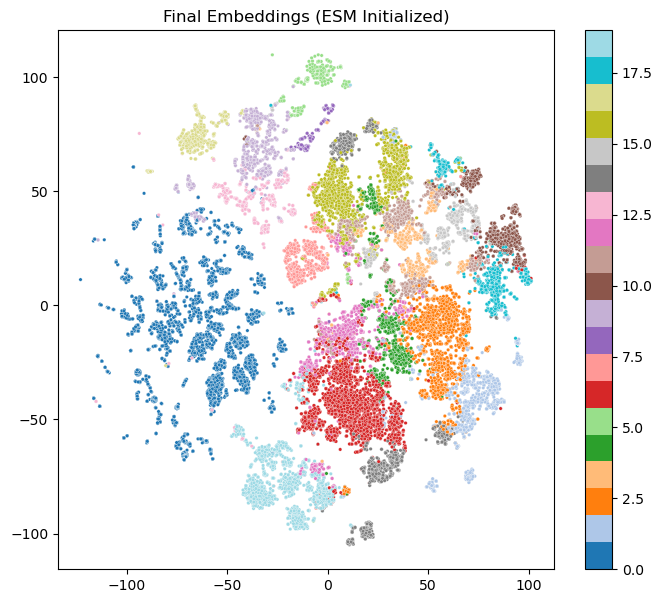

In [16]:
cmap = sns.color_palette("tab20", as_cmap=True)

plt.figure(figsize=(8, 7))
scatter = sns.scatterplot(x=esm_embeddings[:, 0], y=esm_embeddings[:, 1], hue=clusters_final, 
                          palette=cmap, s=6, marker='o', legend=None)

plt.title(f"Final Embeddings (ESM Initialized)")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(clusters_final), vmax=max(clusters_final))))
plt.show()

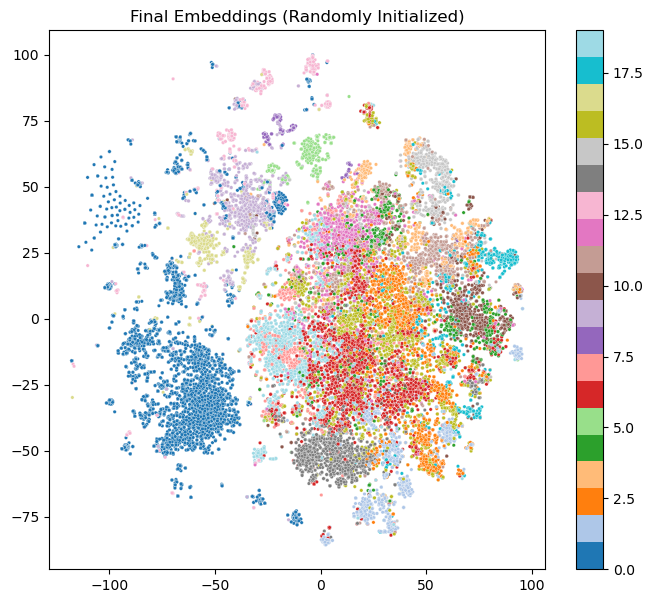

In [17]:
cmap = sns.color_palette("tab20", as_cmap=True)

plt.figure(figsize=(8, 7))
scatter = sns.scatterplot(x=rand_embeddings[:, 0], y=rand_embeddings[:, 1], hue=clusters_final, 
                          palette=cmap, s=6, marker='o', legend=None)

plt.title(f"Final Embeddings (Randomly Initialized)")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(clusters_final), vmax=max(clusters_final))))
plt.show()

In [38]:
labels_for_cluster_6 = [label for label, cluster in zip(labels, clusters_init) if cluster == 6]

In [41]:
labels_for_cluster_5 = [label for label, cluster in zip(labels, clusters_init) if cluster == 5]
labels_for_cluster_18 = [label for label, cluster in zip(labels, clusters_init) if cluster == 18]

In [43]:
labels_for_cluster_5

['ZNF586',
 'ZNF835',
 'ZNF273',
 'ZNF890P',
 'ZNF491',
 'ZNF569',
 'ZNF454',
 'ZNF575',
 'ZNF234',
 'ZNF84',
 'ZNF227',
 'ZNF563',
 'ZNF418',
 'ZNF567',
 'ZNF358',
 'ZNF420',
 'ZNF850',
 'ZNF749',
 'ZNF25',
 'ZNF670',
 'ZNF382',
 'ZNF550',
 'ZNF611',
 'ZNF229',
 'GOLGA6L7',
 'ZNF519',
 'ZNF329',
 'ZNF594',
 'ZNF426',
 'ZNF98',
 'ZKSCAN5',
 'ZNF248',
 'TPT1P8',
 'ZNF41',
 'ZNF286A',
 'ZNF736',
 'ZNF34',
 'ZNF623',
 'RNU6-355P',
 'ZNF517',
 'SEMG1',
 'ZFP92',
 'ZNF182',
 'ZIM2-AS1',
 'ZNF483',
 'ZNF334',
 'ZNF441',
 'LRRC37A3',
 'ZNF763',
 'ZNF101',
 'ZNF302',
 'ZNF665',
 'RBAK',
 'ZNF440',
 'ZNF616',
 'ZNF793',
 'SPDYE1',
 'ZNF253',
 'NBPF19',
 'ZNF813',
 'BBOX1-AS1',
 'ZNF154',
 'ZNF100',
 'ZNF696',
 'ZNF510',
 'ZNF660',
 'GPRASP1',
 'NPIPB11',
 'FAM74A7',
 'AHNAK',
 'ZNF473',
 'ZNF430',
 'ZNF57',
 'ZNF35',
 'ZFP37',
 'ZNF669',
 'ZNF615',
 'SELENOV',
 'ZNF354B',
 'ZNF180',
 'ZNF486',
 'ZNF829',
 'ZNF888',
 'ZNF71',
 'ANKRD30BL',
 'ZNF24',
 'ZNF726P1',
 'SAGE2P',
 'ZNF331',
 'ZNF436',
